In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": "0.9"})
sns.set_context("poster")

from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import backend as K

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Activation

Using TensorFlow backend.


In [3]:
def create_dataset(dataset, look_back=1):

        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):

            #The target is always the next value. And the lookback are the previous prices
            a = dataset[i:(i+look_back), :]
            dataX.append(a)
            dataY.append(dataset[i + look_back, :][0]) #WHATCH OUT WE ISOLATE THE TARGET WITH [0] SO IT MUST BE 1ST

        return np.array(dataX), np.array(dataY)

def run(dataset, look_back, lstm1_neurons, lstm1_dropout, lstm1_recurrent_dropout, lstm2_neurons, 
              lstm2_dropout, lstm2_recurrent_dropout, dense_neurons, batch_size):
    dataset = dataset.values
    dataset = dataset.astype('float32')

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # split into train and test sets
    train_size = int(len(dataset) * 0.80)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

    #Define callbacks
    callbacks = [

                keras.callbacks.EarlyStopping(monitor='loss',patience=3),
                keras.callbacks.ModelCheckpoint(filepath='forecasting_price_model.h5', monitor='val_loss',save_best_only=True),
                keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=1),
                keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
            ]

    # Define Model
    model = Sequential()
    model.add(LSTM(lstm1_neurons, input_shape=(look_back, trainX.shape[2]),
                       dropout = lstm1_dropout, recurrent_dropout=lstm1_recurrent_dropout,return_sequences=True
                      ))

    model.add(LSTM(lstm2_neurons, dropout = lstm2_dropout, recurrent_dropout= lstm2_recurrent_dropout))
    model.add(Dense(dense_neurons))

    model.add(Dense(1))

    def root_mean_squared_error(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

    model.compile(loss=root_mean_squared_error, optimizer='adam' )
    history = model.fit(trainX, trainY, epochs=250, batch_size=batch_size,callbacks=callbacks,validation_split=0.25,)

    model.load_weights("forecasting_price_model.h5")

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[:], trainPredict[:,0]))
    print('\n Train Score: %.5f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[:], testPredict[:,0]))
    print('\n Test Score: %.5f RMSE' % (testScore))

    m_s_e = model.evaluate(testX, testY, verbose=0)

    #plot the loss function
    plt.figure(figsize=(20,10))
    plt.title('Loss Value')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()
    
    #plot the values
    plt.figure(figsize=(20,10))
    plt.title('LSTM Network Prediction vs Real values')
    plt.plot(trainPredict[:,0], label='Prediction')
    plt.plot(trainY[:], label='Real Price')
    plt.legend()
    plt.show()
    
    #plot the values
    plt.figure(figsize=(20,10))
    plt.title('LSTM Network Prediction vs Real values')
    plt.plot(testPredict[:,0], label='Prediction2')
    plt.plot(testY[:], label='Real Price2')
    plt.legend()
    plt.show()

# Univariate Version - Only Price Prediction 

Train on 435 samples, validate on 146 samples
Epoch 1/250
435/435 [==============================] - 4s 10ms/step - loss: 0.0612 - val_loss: 0.0397
Epoch 2/250
435/435 [==============================] - 1s 2ms/step - loss: 0.0242 - val_loss: 0.0223
Epoch 3/250
435/435 [==============================] - 1s 2ms/step - loss: 0.0227 - val_loss: 0.0122
Epoch 4/250
435/435 [==============================] - 1s 2ms/step - loss: 0.0207 - val_loss: 0.0116
Epoch 5/250
435/435 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0243
Epoch 6/250
435/435 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0128
Epoch 7/250
435/435 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0117
Epoch 00007: early stopping

 Train Score: 0.03151 RMSE

 Test Score: 0.01583 RMSE


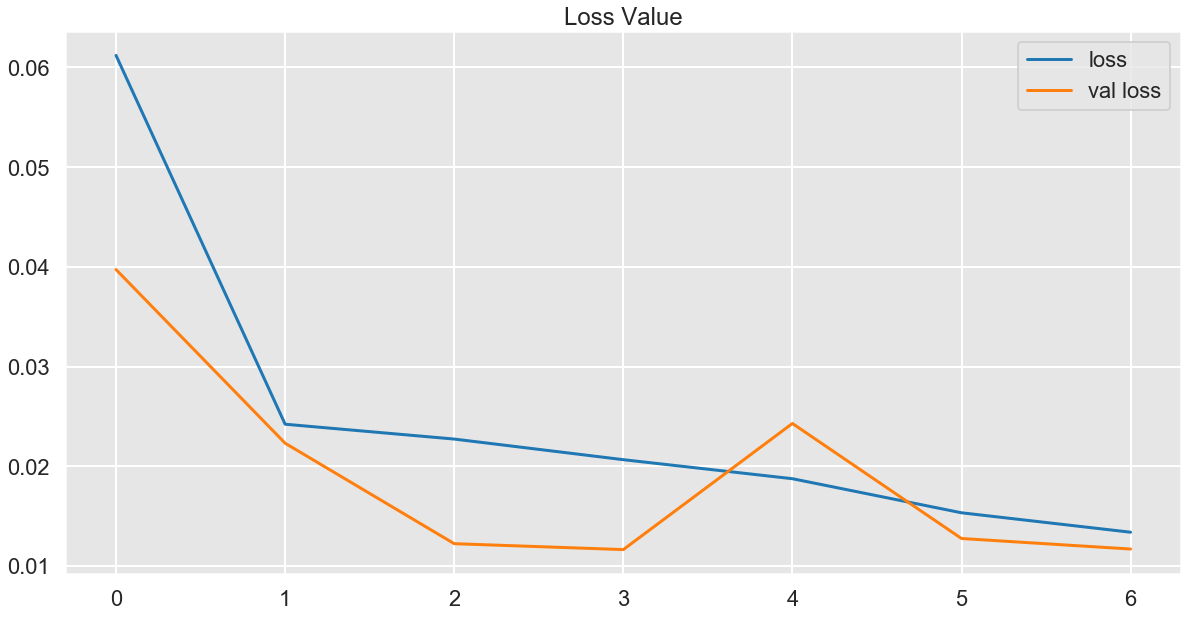

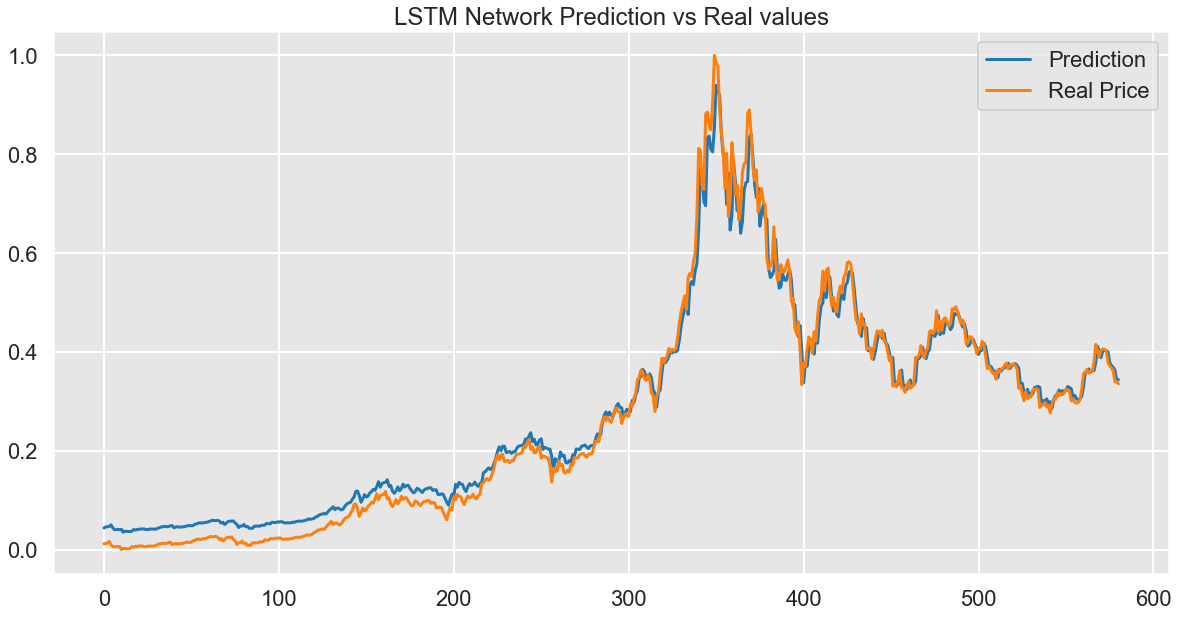

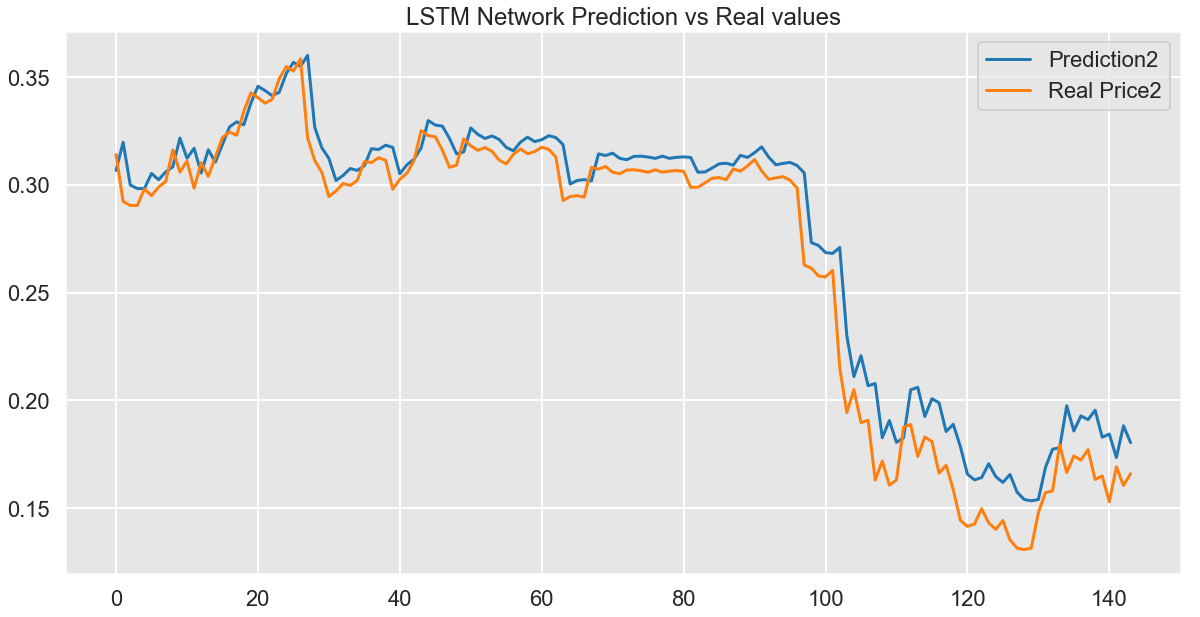

In [3]:
df = pd.read_csv('fulldata.csv')
#Drop np.nan
df.dropna(how='any', inplace=True)

#Make it array
#IT IS IMPORTANT TARGET BE FIRST SO WE CAN ISOLATE IT ON CREATE_DATASET FUNCTION
dataset = df[['Weighted_Price']]

run(dataset,1 , 32, 0.0015560904103964716, 0.43575253645359435, 128, 0.0020795314309861868, 0.4926763902955317, 512, 4)

# Multivariate Version - Price and Twitter features Prediction 

Train on 435 samples, validate on 146 samples
Epoch 1/250
435/435 [==============================] - 5s 12ms/step - loss: 0.0815 - val_loss: 0.0625
Epoch 2/250
435/435 [==============================] - 4s 9ms/step - loss: 0.0432 - val_loss: 0.0559
Epoch 3/250
435/435 [==============================] - 4s 8ms/step - loss: 0.0363 - val_loss: 0.0481
Epoch 4/250
435/435 [==============================] - 4s 9ms/step - loss: 0.0352 - val_loss: 0.0197
Epoch 5/250
435/435 [==============================] - 4s 8ms/step - loss: 0.0349 - val_loss: 0.0374
Epoch 6/250
435/435 [==============================] - 4s 8ms/step - loss: 0.0232 - val_loss: 0.0123
Epoch 7/250
435/435 [==============================] - 4s 8ms/step - loss: 0.0218 - val_loss: 0.0210
Epoch 8/250
435/435 [==============================] - 4s 8ms/step - loss: 0.0217 - val_loss: 0.0158
Epoch 9/250
435/435 [==============================] - 4s 9ms/step - loss: 0.0225 - val_loss: 0.0144
Epoch 00009: early stopping

 Train Score: 0

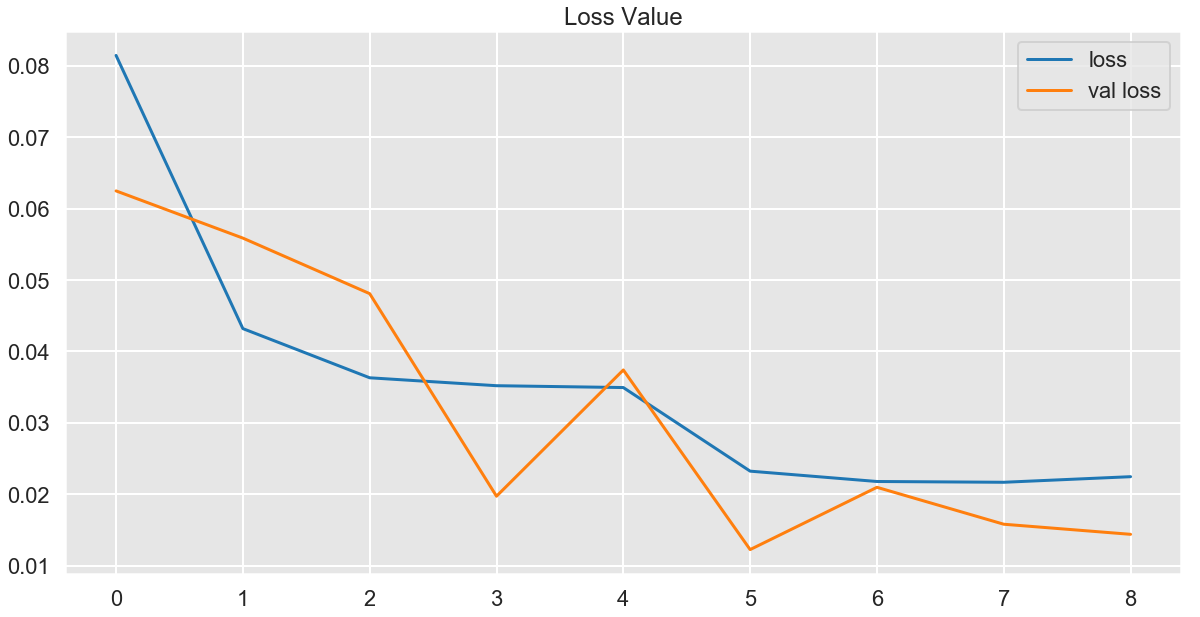

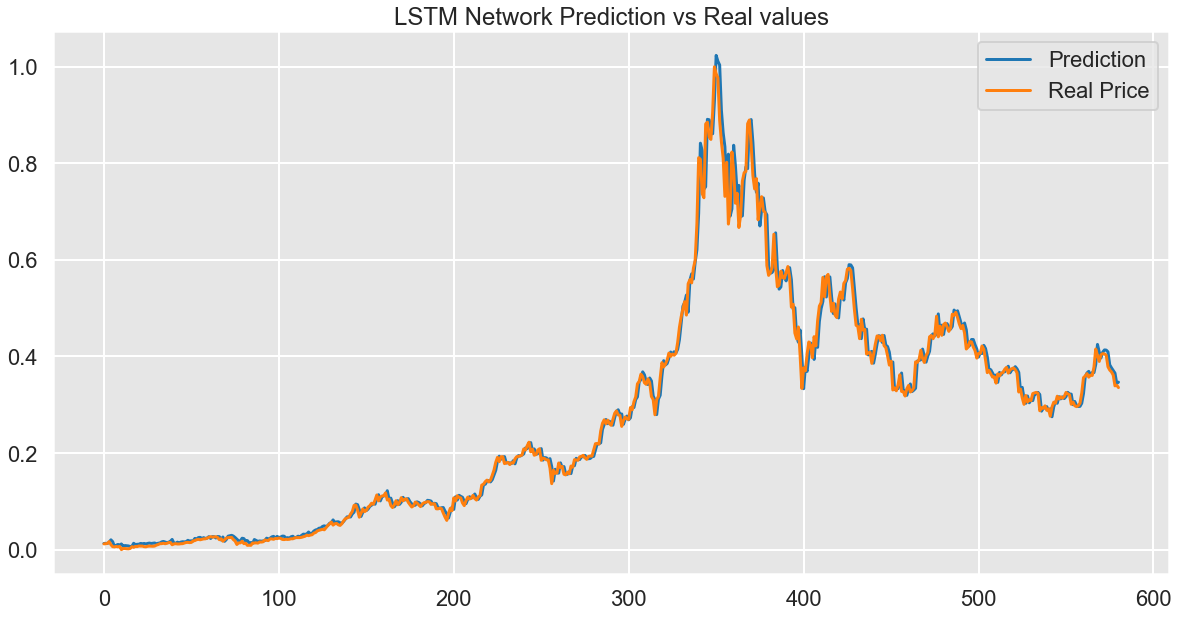

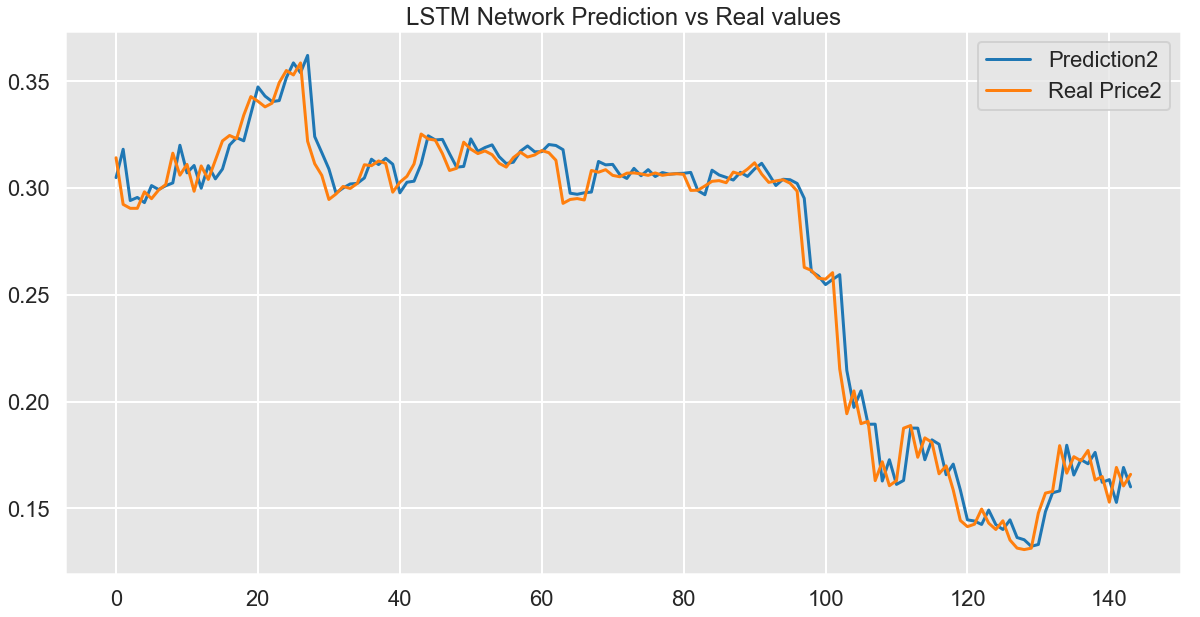

In [6]:
df = pd.read_csv('fulldata.csv')
#Drop np.nan
df.dropna(how='any', inplace=True)

#Make it array
#IT IS IMPORTANT TARGET BE FIRST SO WE CAN ISOLATE IT ON CREATE_DATASET FUNCTION
dataset = df[['Weighted_Price', 'Polarity_Textblob', 'Trend_Values', 'Polarity_Vader']]

run(dataset,1 , 32, 0.0006067792987999934, 0.46202765620423925, 64, 0.16269564959981841, 0.658267704837993, 512, 1)